# Goal: Study the distributions of fertility rate in different geographic regions of the world to test whether their is a significant relationship between their distributions

### Hypotheses

For n geographically coherent samples of country-level fertility rates (births per woman):

- $H_{0}: \mu_{1} = \mu_{2} = \cdots = \mu_{n}$ 

- $H_{a}$: at least one of the equalities is not satisfied

- $\alpha$ = 0.05

The data set can be found at the following URL  
https://data.worldbank.org/indicator/SP.DYN.TFRT.IN

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import Fertility_Data_Processing_Functions as process

# Initialize the Data

In [2]:
fert_data_path = 'data-unzipped-worldbank/SP.DYN.TFRT.IN/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_248489.csv'
fert_meta_data_path = 'data-unzipped-worldbank/SP.DYN.TFRT.IN/Metadata_Country_API_SP.DYN.TFRT.IN_DS2_en_csv_v2_248489.csv'
raw_fertility_df = process.read_worldbank_csv(data_path=fert_data_path,
                                            meta_data_path=fert_meta_data_path)

In [3]:
# Defining the years over which the means will be compared
sampled_years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
                 '2011', '2012', '2013', '2014', '2015', '2016', '2017']
# Generating a cleaned global fertility dataframe with countries missing values removed and the means calculated
fertility_df = process.clean_fertility_data(raw_fertility_df, sampled_years)

# Inspect the fertility rate trends across The World Bank's geographic regions

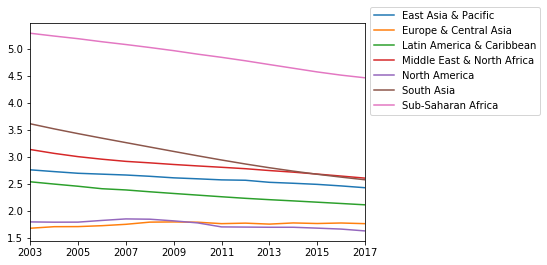

In [4]:
#Graphing the fertility rates over the sampled years to see how the trends compare across regions
fertility_df_by_region = fertility_df.drop(['sampled_mean'],
                                           axis=1).groupby('region').mean()
fertility_df_by_region.T.plot()
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1.1), bbox_transform=ax.transAxes)
plt.savefig('500-Fertility_Rate_Trends.png', dpi=300, bbox_inches='tight')
plt.show();

- Sub-Saharan (SS) Africa was the largest outlier with South Asia second.  
- Both of them also showed the most pronounced trend towards the rates of other geographic regions.  
- They also has disproportionately lower incomes, which corresponds to higher fertility rates.   
- For these reasons, those two regions will be considered for exclusion from the analysis.  

In [5]:
# Creating subsets of the data to analyze how the global distribution looks
# when SS Africa is excluded and when both SS Africa and South Asia are excluded.

# SS Africa removed:
exclude_ss_africa = fertility_df.loc[fertility_df.region != 'Sub-Saharan Africa'].copy()
exclude_ss_africa.reset_index(inplace=True, drop=True)

# SS Africa and S Asia removed:
exclude_ss_africa_s_asia = fertility_df.loc[(fertility_df.region != 'Sub-Saharan Africa')
                                              & (fertility_df.region != 'South Asia')].copy()
exclude_ss_africa_s_asia.reset_index(inplace=True, drop=True)

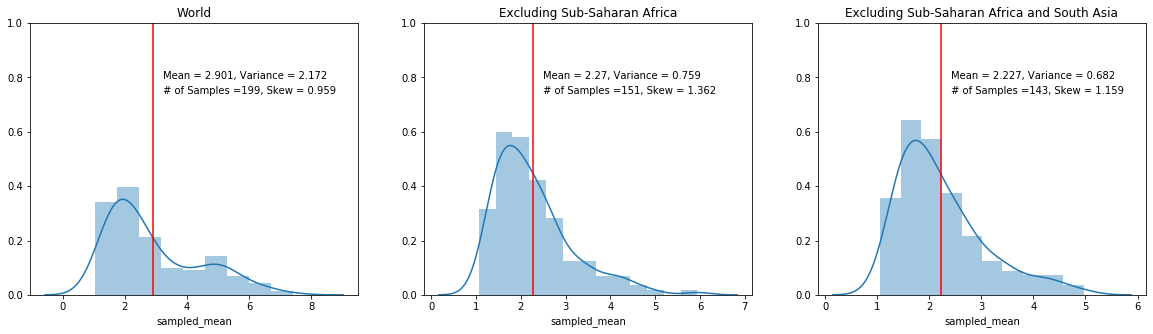

In [6]:
# Plotting the distributions
explore_dfs_list = [fertility_df,
                    exclude_ss_africa,
                    exclude_ss_africa_s_asia]

explore_titles_list = ['World', 'Excluding Sub-Saharan Africa',
                       'Excluding Sub-Saharan Africa and South Asia']

process.dist_plots(dfs_list=explore_dfs_list,
                   titles_list=explore_titles_list,
                   sample_col='sampled_mean',
                   png_title="500-Population_Distributions")

- When excluding SS Africa and South Asia the distributions become less positively skewed, so they will be excluded from further analysis.  
- Further statistical analysis will be pursued for the remaining geographies.

# Analyzing the distributions of Eurasia, East Asia, and Americas

In [7]:
# The following subsets were selected due to their sharing of geographic boundaries and their mix between
# high fertility rate (generally lower income) and lower fertility rate (generally higher income) countries.

# Creating a subset for just Eurasia
eurasia = fertility_df.loc[(fertility_df.region == 'Europe & Central Asia')
                           | (fertility_df.region == 'Middle East & North Africa')].copy()
eurasia.reset_index(inplace=True, drop=True)

# Creating a sample of the Americas
americas = fertility_df.loc[(fertility_df.region == 'Latin America & Caribbean')
                            | (fertility_df.region == 'North America')].copy()
americas.reset_index(inplace=True, drop=True)

# Creating a sample of just East Asia
east_asia = fertility_df.loc[fertility_df.region == 'East Asia & Pacific'].copy()
east_asia.reset_index(inplace=True, drop=True)

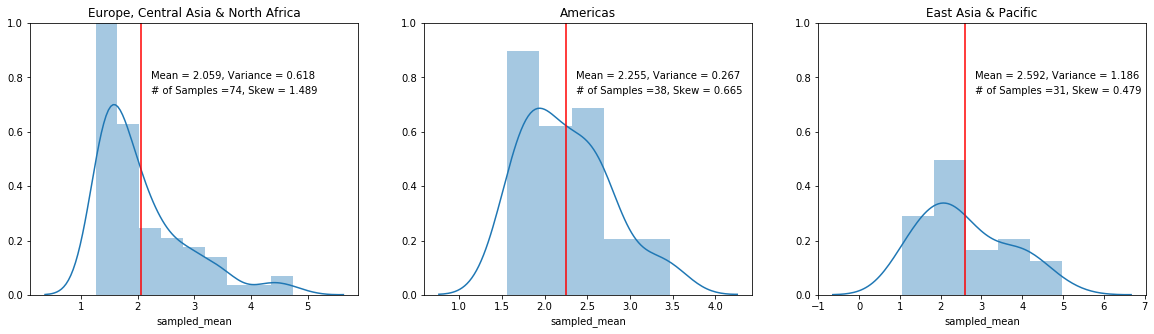

In [8]:
sample_dfs_list = [eurasia, americas, east_asia]

sample_titles_list = ['Europe, Central Asia & North Africa',
                      'Americas', 'East Asia & Pacific']

process.dist_plots(dfs_list=sample_dfs_list,
                   titles_list=sample_titles_list,
                   sample_col='sampled_mean',
                   png_title='500-Sample_Distributions')

- The distributions show a positive skew with some normality. They do not exhibit homoscedasticity.  
- The rule of thumb for acceptable skewness is -0.5 to 0.5  
- Eurasia is significantly skewed, Americas is somewhat skewed and East Asia is mildly skewed.  
- The variances exhibit significant homoscedasticity with the minimum value more than 4 time the maximum value. 
- Independence may be undermined by cultural and economic links based on geographic proximity.

# Performing statistical tests

- Welch's t-test will be performd to account for the homoscedasticity.
- The variance of Americas and Eurasia are close enough to consider Tukey's, so that test will be performed on all for exploratory purposes, but the Welch's t-test will be used to evaluate the hypotheses.
- ANOVA testing of all three will not be performed due to the homoscedasticity.

In [9]:
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [10]:
sample_list = [exclude_ss_africa_s_asia['sampled_mean'], americas['sampled_mean'],
               east_asia['sampled_mean'], eurasia['sampled_mean']]
group_list = ['Population', 'Americas', 'East Asia', 'Eurasia']

stats_df = process.three_way_welch_test_w_pop(sample_list, group_list, 0.05)
stats_df.head(6)

,Group_1,Group_2,t-stat,p_value,Reject
0,Population,Americas,-0.2652,0.7914,False
1,Population,East Asia,-1.7592,0.0866,False
2,Population,Eurasia,1.4640,0.1452,False
3,Americas,East Asia,-1.5796,0.1219,False
4,Americas,Eurasia,1.5848,0.1161,False
5,East Asia,Eurasia,2.4669,0.0176,True


In [11]:
eurasia['group'] = 'Eurasia'
east_asia['group'] = 'East Asia'
americas['group'] = 'Americas'
exclude_ss_africa_s_asia['group'] = 'Population'
tukey_data = pd.concat([exclude_ss_africa_s_asia, east_asia, eurasia, americas])

In [12]:
mc = MultiComparison(tukey_data['sampled_mean'],
                     tukey_data['group'])
result = mc.tukeyhsd()
print(result)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj   lower   upper  reject
-----------------------------------------------------------
 Americas  East Asia   0.3362 0.3235 -0.1737  0.8461  False
 Americas    Eurasia  -0.1965 0.6079 -0.6169   0.224  False
 Americas Population  -0.0288    0.9 -0.4133  0.3557  False
East Asia    Eurasia  -0.5327 0.0131 -0.9834 -0.0819   True
East Asia Population   -0.365 0.1101 -0.7824  0.0524  False
  Eurasia Population   0.1677 0.4784  -0.134  0.4694  False
-----------------------------------------------------------


In [13]:
sample_series_list = [eurasia['sampled_mean'], americas['sampled_mean'], east_asia['sampled_mean']]

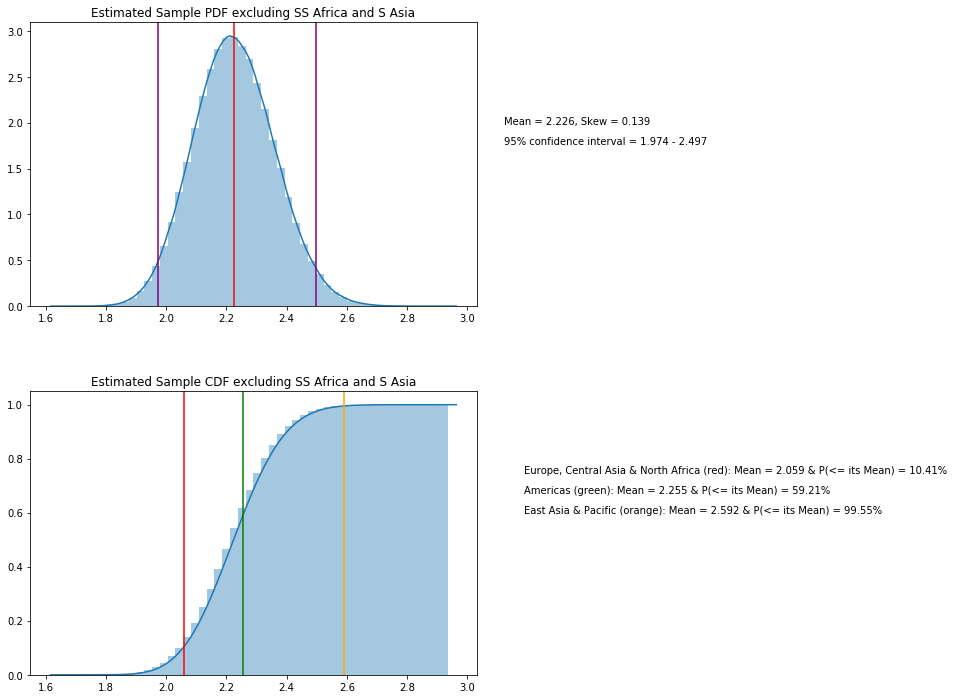

In [14]:
# Plotting the PDF and CDF based on 100,000 random samples of 30 countries.
# Replacement was not seen to affect the results significantly.
process.point_estimate_distributions(sample_input=exclude_ss_africa_s_asia['sampled_mean'],
                                     sub_samples_list=sample_series_list,
                                     sub_samples_titles=sample_titles_list,
                                     replacement=False)

# Conclusions:

1) The null hypothesis is rejected because East Asia's mean deviated from Eurasia's by a statistically significant amount.

2) The samples show some indication that they are from the same population, but the skew of the population prevents sufficient normality and there is too much variance for the statistical tests to be interpreted with high confidence.  
  
3) The Americas are most similar to the Population among the samples examined.  

4) The mean of East Asia is very high relative to the population with 98.9% of similarly sized samples (30 vs. 31) having a lower mean.